In [149]:
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme
from fuel.datasets.hdf5 import H5PYDataset
from fuel.server import start_server
from fuel.transformers import Flatten, ScaleAndShift
from fuel.transformers.image import  Random2DRotation
from fuel.transformers.video import RescaleMinDimension
from custom_transformers_kaggle import RandomLimit, RandomFixedSizeCrop, Normalize, Cast, RandomRotate, ZeroPadding
import math
import math

# number_train = 494 (counting valid set)

train_set = H5PYDataset(
	'./data_kaggle/kaggle_heart.hdf5',
	which_sets=('train',),
	subset=slice(0, 450), #450
	load_in_memory=True
)

valid_set = H5PYDataset(
	'./data_kaggle/kaggle_heart.hdf5',
	which_sets=('train',),
	subset=slice(451, 494), 
	load_in_memory=True
)

valid_stream = DataStream.default_stream(
    valid_set,
    iteration_scheme=ShuffledScheme(valid_set.num_examples, 10)
)

index_cases   = 0
index_mult    = 1
index_sax     = 2
index_images  = 3
index_targets = 4

stream = DataStream.default_stream(
    train_set,
    iteration_scheme=ShuffledScheme(train_set.num_examples, 450)
)


In [150]:
it = stream.get_epoch_iterator()
it_valid = valid_stream.get_epoch_iterator()

In [151]:
data = it.next()
valid_data=it_valid.next()

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import gaussian_process
X = np.atleast_2d(data[index_targets][:,0] + np.random.normal(0,.01,450)).T
Y = data[index_targets][:,1] + np.random.normal(0,.01,450)

In [177]:
gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, thetaU=1e-1, nugget=(.01), regr='linear')
gp.fit(X, Y)

GaussianProcess(beta0=None,
        corr=<function squared_exponential at 0x10ce70848>, normalize=True,
        nugget=array(0.01), optimizer='fmin_cobyla', random_start=1,
        random_state=<mtrand.RandomState object at 0x107537890>,
        regr=<function linear at 0x10ce70500>, storage_mode='full',
        theta0=array([[ 0.01]]), thetaL=array([[ 0.0001]]),
        thetaU=array([[ 0.1]]), verbose=False)

In [178]:
x = np.atleast_2d(np.linspace(0, 500, 1000)).T

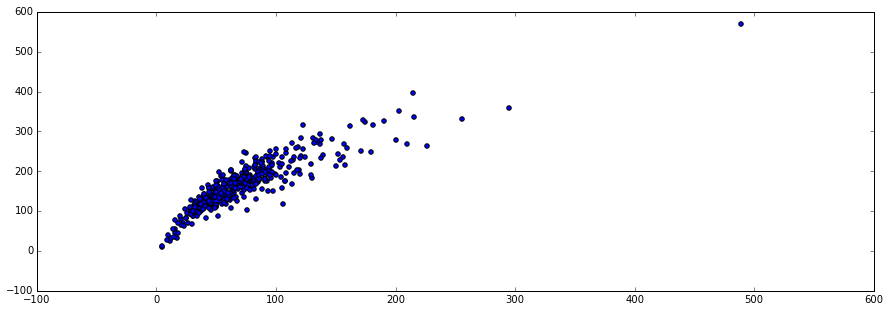

In [179]:
plt.figure(figsize=(15, 5))
plt.scatter(data[index_targets][:,0], data[index_targets][:,1])

In [180]:
y_pred, sigma2_pred = gp.predict(x, eval_MSE=True)

[0, 500, 0, 1000]

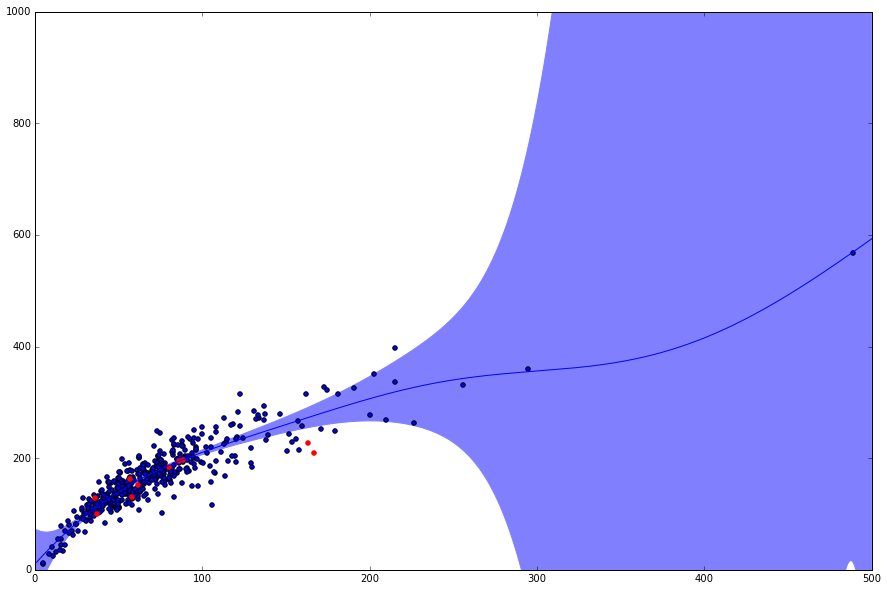

In [181]:
plt.figure(figsize=(15, 10))
plt.plot(x[:,0], y_pred);plt.hold(True);
plt.fill_between(x[:,0], y_pred - sigma2_pred, y_pred + sigma2_pred,facecolor=[.5,.5,1], color=[.5,.5,1]) 
plt.scatter(data[index_targets][:,0], data[index_targets][:,1])
plt.scatter(valid_data[index_targets][:,0], valid_data[index_targets][:,1], color='red')
plt.axis([0,500,0,1000])